In [1]:
#########  load packages and data

import numpy as np 
import pandas as pd 
import xgboost as xgb
from xgboost import cv
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import category_encoders as ce 
import optuna

plt.style.use('ggplot')

data_learn = pd.read_csv('learn.csv')
data_test = pd.read_csv('test.csv')

In [2]:
#########  feature pre-processing

data_learn["ClaimNb"] = data_learn["ClaimNb"].clip(upper=4)
data_learn["BonusMalus_capped"]= np.clip(data_learn.BonusMalus, None, 150)
data_learn["VehAge_capped"]= np.clip(data_learn.VehAge, None, 30)
data_learn["DrivAge_capped"]= np.clip(data_learn.DrivAge, None, 85)
data_learn['LogDensity'] = np.log(data_learn['Density'])


data_test["ClaimNb"] = data_test["ClaimNb"].clip(upper=4)
data_test["BonusMalus_capped"]= np.clip(data_test.BonusMalus, None, 150)
data_test["VehAge_capped"]= np.clip(data_test.VehAge, None, 30)
data_test["DrivAge_capped"]= np.clip(data_test.DrivAge, None, 85)
data_test['LogDensity'] = np.log(data_test['Density'])

In [3]:
# marque de la voiture
def VehBrand_class(data):

    Brand = np.array(data["VehBrand"])

    VehBrand_classe = []
    for i in range(0, len(data)):
        
        if Brand[i] in ['B2', 'B4', 'B6', 'B10', 'B1']:
            VehBrand_classe.append('C1')

        elif Brand[i] in ['B3', 'B11', 'B5', 'B13', 'B14']:
            VehBrand_classe.append('C2')

        else:
            VehBrand_classe.append('C4')

    data["VehBrand_class"]=VehBrand_classe
        
    return data

data_learn = VehBrand_class(data_learn)
data_test = VehBrand_class(data_test)

#la zone d'habitation
def Area_class(data):

    Area = np.array(data["Area"])

    Area_classe = []
    for i in range(0, len(data)):
        
        if Area[i] in ['A', 'B', 'C']:
            Area_classe.append('C1')

        elif Area[i] in ['D']:
            Area_classe.append('C2')

        elif Area[i] in ['E']:
            Area_classe.append('C3')

        else:
            Area_classe.append('C4')

    data["Area_class"]=Area_classe
        
    return data

data_learn = Area_class(data_learn)
data_test = Area_class(data_test)

#region d'habitation
def Region_class(data):

    Region = np.array(data["Region"])

    Region_classe = []
    for i in range(0, len(data)):
        
        if Region[i] in ['R21', 'R94', 'R11', 'R22', 'R74']:
            Region_classe.append('C1')

        elif Region[i] in ['R91', 'R82', 'R42']:
            Region_classe.append('C2')

        elif Region[i] in ['R93', 'R53']:
            Region_classe.append('C3')

        elif Region[i] in ['R26', 'R25', 'R52', 'R31', 'R54', 'R73', 
                                'R23', 'R72', 'R83', 'R41', 'R43', 'R24']:
            Region_classe.append('C4')

    data["Region_class"]=Region_classe
        
    return data

data_learn = Region_class(data_learn)
data_test = Region_class(data_test)

In [4]:
# Function PD: Calculate Poisson Deviance
def PD_function(pred, obs):
    PD = 200*( sum(pred) - sum(obs) + sum( np.log( (obs/pred)**(obs) ) ) )
    return PD/len(pred)

# Function PD2: Print Poisson Deviance learn/test
def PD2_function(txt, l_c, l_x, t_c, t_x):
    print("{:s}, Train/Valid: {:.4f} / {:.4f}".format(txt, PD_function(l_c, l_x), PD_function(t_c, t_x)))

In [5]:
import category_encoders as ce   # version 1.2.8

ce_ord = ce.one_hot.OneHotEncoder(cols = ['Region_class', "Area_class", "VehBrand_class", "VehGas"])
data_learn_ = ce_ord.fit_transform(data_learn, data_learn["ClaimNb"])
data_test_ = ce_ord.fit_transform(data_test, data_test["ClaimNb"])

/home/krasniqi/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/krasniqi/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [6]:
#### columns taht we don't need
data_learn_ = data_learn_.drop(['Area','ClaimAmount', 'DrivAge', 'BonusMalus','VehBrand',
                                'Density', 'Region', 'VehAge'], axis=1)

data_test_ = data_test_.drop(['Area','ClaimAmount', 'DrivAge', 'BonusMalus','VehBrand',
                                'Density', 'Region', 'VehAge'], axis=1)

In [7]:
#train
y_train = data_learn_.filter(['ClaimNb'])
log_exp_train= np.log(data_learn_.filter(['Exposure']))
x_train = data_learn_.drop(columns=['ClaimNb', 'Exposure'])

#valid
y_valid = data_test_.filter(['ClaimNb'])
log_exp_valid = np.log(data_test_.filter(['Exposure']))
x_valid = data_test_.drop(columns=['ClaimNb', 'Exposure'])

## 1. Binary Model

In [8]:
xgb_clf_params = {'learning_rate': 0.0112858876989048,
 'booster': 'gbtree',
 'lambda': 0.20285597021115936,
 'alpha': 0.0003025298842452404,
 'subsample': 0.657945504955294,
 'colsample_bytree': 0.7802558158701174,
 'max_depth': 7,
 'min_child_weight': 5,
 'eta': 3.360411524776418e-05,
 'gamma': 1.7396619505750592e-07,
 'grow_policy': 'depthwise',
 'objective': 'binary:logistic',
 'n_estimators': 2000}

xgb_binaire = xgb.XGBClassifier(**xgb_clf_params)

xgb_binaire.fit(X=x_train, y=y_train > 0, 
                base_margin=log_exp_train,
                eval_set=[(x_train, y_train > 0), (x_valid, y_valid>0)],
                eval_metric=["logloss"], verbose=100, 
                early_stopping_rounds=15)

/home/krasniqi/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68609	validation_1-logloss:0.68627
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[100]	validation_0-logloss:0.32771	validation_1-logloss:0.33100
[200]	validation_0-logloss:0.23974	validation_1-logloss:0.24423
[300]	validation_0-logloss:0.21658	validation_1-logloss:0.22204
[400]	validation_0-logloss:0.20977	validation_1-logloss:0.21594
[500]	validation_0-logloss:0.20724	validation_1-logloss:0.21427
[600]	validation_0-logloss:0.20610	validation_1-logloss:0.21374
Stopping. Best iteration:
[648]	validation_0-logloss:0.20571	validation_1-logloss:0.21366



XGBClassifier(alpha=0.0003025298842452404, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7802558158701174, eta=3.360411524776418e-05,
              gamma=1.7396619505750592e-07, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              lambda=0.20285597021115936, learning_rate=0.0112858876989048,
              max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.000302529894,
              reg_lambda=0.202855974, scale_pos_weight=1,
              subsample=0.657945504955294, tree_method='exact',
              validate_parameters=1, verbosity=None)

## 2. Poisson zero truncated Model

In [9]:
#only positiv  ClaimNb
dmat_train = xgb.DMatrix(x_train[y_train.ClaimNb >0], y_train[y_train.ClaimNb >0])
dmat_valid = xgb.DMatrix(x_valid[y_valid.ClaimNb >0], y_valid[y_valid.ClaimNb >0])

In [10]:
def first_grad(predt, dtrain):
    '''Compute the first derivative.'''
    y = dtrain.get_label() if isinstance(dtrain, xgb.DMatrix) else dtrain
    return (-y/predt) +(np.exp(predt)/(np.exp(predt)-1))

def second_grad(predt, dtrain):
    '''Compute the second derivative.'''
    y = dtrain.get_label() if isinstance(dtrain, xgb.DMatrix) else dtrain
    return (y/predt**2 - (np.exp(predt)/(np.exp(predt)-1)**2)) 

def PoissonZeroNegLogLik(predt, dtrain):
    ''''Mean squared error function.'''
    predt[predt < 0] = 0 + 1e-6
    grad = first_grad(predt, dtrain)
    hess = second_grad(predt, dtrain)
    return grad, hess

def EvalPoissonZeroNegLogLik(preds: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    actuals = dtrain.get_label()
    preds[preds < 0] = 1e-6
    resultats = -actuals * np.log(preds) + np.log(np.exp(preds)-1)
    return "ZIdev", float(np.sum(resultats)/len(preds))

In [38]:
params = {'learning_rate': 0.005244699573929688,
 'booster': 'gbtree',
 'lambda': 0.0009062424575469218,
 'alpha': 2.8543406763066105e-08,
 'subsample': 0.8152933049730727,
 'colsample_bytree': 0.830977185223346,
 'max_depth': 4,
 'min_child_weight': 2,
 'eta': 0.005397189828785509,
 'gamma': 6.912818503629075e-06,
 'grow_policy': 'lossguide'}

results: Dict[str, Dict[str, List[float]]] = {}
    
booster =xgb.train(params, 
                   dtrain=dmat_train, 
                   num_boost_round=2000,
                   obj=PoissonZeroNegLogLik, 
                   feval=EvalPoissonZeroNegLogLik,
                   evals=[(dmat_train, 'dtrain'), (dmat_valid, 'dtest')],
                   early_stopping_rounds=10, 
                   evals_result=results)

[0]	dtrain-rmse:0.61993	dtest-rmse:0.61520	dtrain-ZIdev:0.29790	dtest-ZIdev:0.29634
Multiple eval metrics have been passed: 'dtest-ZIdev' will be used for early stopping.

Will train until dtest-ZIdev hasn't improved in 10 rounds.
[1]	dtrain-rmse:0.62685	dtest-rmse:0.62181	dtrain-ZIdev:0.29457	dtest-ZIdev:0.29322
[2]	dtrain-rmse:0.63367	dtest-rmse:0.62870	dtrain-ZIdev:0.29133	dtest-ZIdev:0.28995
[3]	dtrain-rmse:0.64005	dtest-rmse:0.63419	dtrain-ZIdev:0.28835	dtest-ZIdev:0.28742
[4]	dtrain-rmse:0.64634	dtest-rmse:0.63998	dtrain-ZIdev:0.28541	dtest-ZIdev:0.28476
[5]	dtrain-rmse:0.65257	dtest-rmse:0.64602	dtrain-ZIdev:0.28252	dtest-ZIdev:0.28203
[6]	dtrain-rmse:0.65861	dtest-rmse:0.65213	dtrain-ZIdev:0.27972	dtest-ZIdev:0.27923
[7]	dtrain-rmse:0.66442	dtest-rmse:0.65750	dtrain-ZIdev:0.27707	dtest-ZIdev:0.27678
[8]	dtrain-rmse:0.67021	dtest-rmse:0.66317	dtrain-ZIdev:0.27444	dtest-ZIdev:0.27426
[9]	dtrain-rmse:0.67603	dtest-rmse:0.66903	dtrain-ZIdev:0.27180	dtest-ZIdev:0.27160
[10]	dtrain-r

[95]	dtrain-rmse:0.85164	dtest-rmse:0.84923	dtrain-ZIdev:0.20257	dtest-ZIdev:0.20352
[96]	dtrain-rmse:0.85165	dtest-rmse:0.84925	dtrain-ZIdev:0.20257	dtest-ZIdev:0.20353
[97]	dtrain-rmse:0.85183	dtest-rmse:0.84946	dtrain-ZIdev:0.20251	dtest-ZIdev:0.20350
[98]	dtrain-rmse:0.85193	dtest-rmse:0.84964	dtrain-ZIdev:0.20247	dtest-ZIdev:0.20343
[99]	dtrain-rmse:0.85193	dtest-rmse:0.84964	dtrain-ZIdev:0.20247	dtest-ZIdev:0.20343
[100]	dtrain-rmse:0.85193	dtest-rmse:0.84964	dtrain-ZIdev:0.20247	dtest-ZIdev:0.20343
[101]	dtrain-rmse:0.85193	dtest-rmse:0.84964	dtrain-ZIdev:0.20247	dtest-ZIdev:0.20343
[102]	dtrain-rmse:0.85193	dtest-rmse:0.84964	dtrain-ZIdev:0.20247	dtest-ZIdev:0.20343
[103]	dtrain-rmse:0.85249	dtest-rmse:0.85022	dtrain-ZIdev:0.20226	dtest-ZIdev:0.20320
[104]	dtrain-rmse:0.85249	dtest-rmse:0.85023	dtrain-ZIdev:0.20226	dtest-ZIdev:0.20320
[105]	dtrain-rmse:0.85249	dtest-rmse:0.85023	dtrain-ZIdev:0.20225	dtest-ZIdev:0.20320
[106]	dtrain-rmse:0.85284	dtest-rmse:0.85062	dtrain-ZIdev:0

[191]	dtrain-rmse:0.86319	dtest-rmse:0.86412	dtrain-ZIdev:0.19823	dtest-ZIdev:0.19959
[192]	dtrain-rmse:0.86325	dtest-rmse:0.86419	dtrain-ZIdev:0.19821	dtest-ZIdev:0.19957
[193]	dtrain-rmse:0.86350	dtest-rmse:0.86443	dtrain-ZIdev:0.19808	dtest-ZIdev:0.19957
[194]	dtrain-rmse:0.86350	dtest-rmse:0.86443	dtrain-ZIdev:0.19808	dtest-ZIdev:0.19956
[195]	dtrain-rmse:0.86360	dtest-rmse:0.86454	dtrain-ZIdev:0.19805	dtest-ZIdev:0.19952
[196]	dtrain-rmse:0.86360	dtest-rmse:0.86454	dtrain-ZIdev:0.19805	dtest-ZIdev:0.19952
[197]	dtrain-rmse:0.86392	dtest-rmse:0.86484	dtrain-ZIdev:0.19790	dtest-ZIdev:0.19947
[198]	dtrain-rmse:0.86392	dtest-rmse:0.86484	dtrain-ZIdev:0.19790	dtest-ZIdev:0.19947
[199]	dtrain-rmse:0.86392	dtest-rmse:0.86484	dtrain-ZIdev:0.19790	dtest-ZIdev:0.19946
[200]	dtrain-rmse:0.86392	dtest-rmse:0.86484	dtrain-ZIdev:0.19790	dtest-ZIdev:0.19946
[201]	dtrain-rmse:0.86409	dtest-rmse:0.86500	dtrain-ZIdev:0.19784	dtest-ZIdev:0.19942
[202]	dtrain-rmse:0.86440	dtest-rmse:0.86532	dtrain-ZI

# Prédiction

In [39]:
def predict_expected_value_strat_1(X_b, offset, X_p, xgb_B, xgb_P, plot=False):

    output_B = xgb_B.predict_proba(X_b, base_margin=offset)[:, 1]
    output_P = xgb_P.predict(X_p)
    output_P_ = ((output_P*np.exp(output_P))/(np.exp(output_P)-1))
    
    if plot == True:
        ax = sns.boxplot(x=output_B)
        plt.title('output_B')
        plt.xlabel("Frequency")
        plt.show()
        print(np.mean(output_B), np.median(output_B), 
              np.std(output_B), np.min(output_B), np.max(output_B))

        ax = sns.boxplot(x=output_P_)
        plt.title('output_P')
        plt.xlabel("Frequency")
        plt.show()
        print(np.mean(output_P_), np.median(output_P_), 
              np.std(output_P_), np.min(output_P_), np.max(output_P_))
    
    return output_B*output_P_

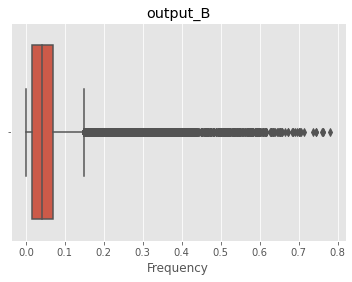

0.051160697 0.04194145 0.05274714 6.840343e-05 0.78088176


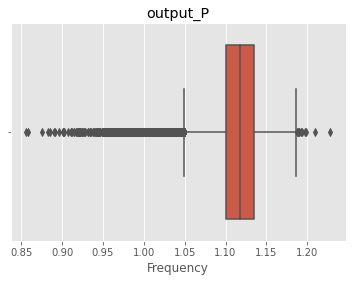

1.1140853 1.1179254 0.03080519 0.85570174 1.2282424


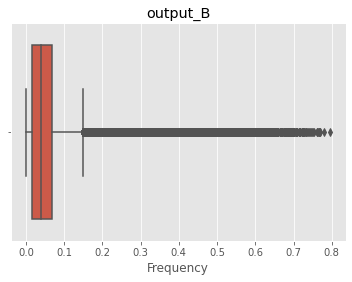

0.050159283 0.04031206 0.05272002 5.2275842e-05 0.7961453


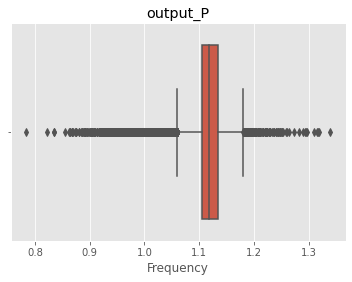

1.1160779 1.1172514 0.02740161 0.7835487 1.3394625
CPU times: user 53.8 s, sys: 464 ms, total: 54.3 s
Wall time: 6.19 s


In [40]:
%%time

dmat_train_ = xgb.DMatrix(x_train, y_train)
dmat_valid_ = xgb.DMatrix(x_valid, y_valid)

predictions_valid = predict_expected_value_strat_1(x_valid, log_exp_valid, dmat_valid_, xgb_binaire, booster, plot=True)

predictions_train = predict_expected_value_strat_1(x_train, log_exp_train, dmat_train_, xgb_binaire, booster, plot=True)
    
#deviance
df_poisson = pd.DataFrame()
table_modal= [np.round(PD_function(predictions_train, y_train['ClaimNb']),6),
                  np.round(PD_function(predictions_valid, y_valid['ClaimNb']),6),
                  sum(predictions_train),
                  sum(predictions_valid), 
                  sum(y_train['ClaimNb']),
                  sum(y_valid['ClaimNb'])
                 ]
table_name = ["deviance_p_train", "deviance_p_test",
              "freq_pred_train", "freq_pred_test", "freq_obs_train", "freq_obs_test"]
    
cnt = dict()
k=0
for word in table_name:
    cnt[word] = table_modal[k]
    k = k+1
df_poisson = df_poisson.append(cnt, ignore_index=True)
    
cf_matrix_train = confusion_matrix(y_train['ClaimNb'], np.round(predictions_train).astype(int))
cf_matrix_valid = confusion_matrix(y_valid['ClaimNb'], np.round(predictions_valid).astype(int))


In [41]:
df_poisson[["deviance_p_train", "deviance_p_test", 
            "freq_pred_train", "freq_pred_test", "freq_obs_train", "freq_obs_test"]]

,deviance_p_train,deviance_p_test,freq_pred_train,freq_pred_test,freq_obs_train,freq_obs_test
0,29.247027,30.350431,32327.132338,5808.496544,30530.0,5526.0


In [42]:
print((32327.132338-30530.0)/30530.0*100)
print((5808.496544-5526.0)/5312.0*100)

5.886447225679658
5.318082530120475


In [43]:
cf_matrix_train

array([[546696,    766,      0,      0,      0],
       [ 26708,    520,      0,      0,      0],
       [  1476,     42,      0,      0,      0],
       [    69,      1,      0,      0,      0],
       [    14,      0,      0,      0,      0]])

In [44]:
cf_matrix_valid

array([[96324,   144,     0,     0,     0],
       [ 4864,    86,     0,     0,     0],
       [  263,     3,     0,     0,     0],
       [   12,     0,     0,     0,     0],
       [    2,     0,     0,     0,     0]])

<AxesSubplot:title={'center':'Feature importance: Binary XGBoost'}, xlabel='F score', ylabel='Features'>

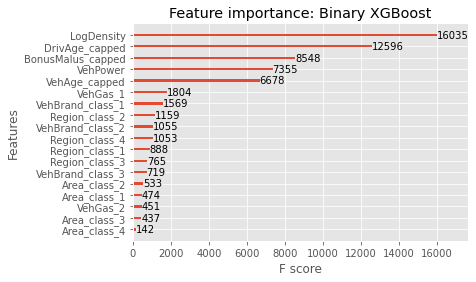

In [45]:
plot_importance(xgb_binaire, title='Feature importance: Binary XGBoost')

<AxesSubplot:title={'center':'Feature importance: Poisson Zero Truncated XGBoost'}, xlabel='F score', ylabel='Features'>

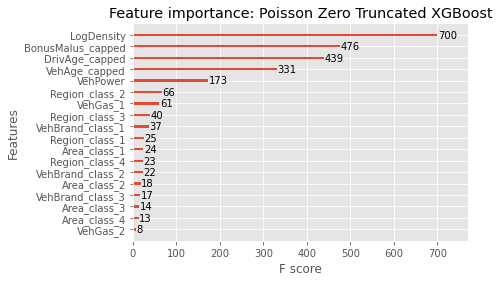

In [46]:
plot_importance(booster, title='Feature importance: Poisson Zero Truncated XGBoost')